<a href="https://colab.research.google.com/github/DARK-ERLIK/DZ_vcard/blob/main/TensorFlow_Flowers_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install matplotlib numpy pillow tensorflow

Импортируем нужные модули, датасет и выводим кол.во изображений в датасете

In [4]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Указываем правильный путь к папке с изображениями
dataset_dir = "/content/flower_photos/flower_photos"
dataset_pathlib = pathlib.Path(dataset_dir)

# Проверяем, что папка существует
if not dataset_pathlib.exists():
    print(f"Ошибка: папка {dataset_dir} не найдена!")
else:
    print(f"Директория датасета: {dataset_pathlib}")
    print(f"Примеры категорий (папок): {list(dataset_pathlib.glob('*'))}")

    # Подсчёт изображений (ищем во всех подпапках)
    image_count = len(list(dataset_pathlib.glob("*/*.jpg")))
    print(f"Всего изображений: {image_count}")


Директория датасета: /content/flower_photos/flower_photos
Примеры категорий (папок): [PosixPath('/content/flower_photos/flower_photos/roses'), PosixPath('/content/flower_photos/flower_photos/tulips'), PosixPath('/content/flower_photos/flower_photos/dandelion'), PosixPath('/content/flower_photos/flower_photos/daisy'), PosixPath('/content/flower_photos/flower_photos/LICENSE.txt'), PosixPath('/content/flower_photos/flower_photos/sunflowers')]
Всего изображений: 3670


Создаем датасеты и кешируем их

In [5]:
batch_size = 32
img_width = 180
img_height = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
	dataset_dir,
	validation_split=0.2,
	subset="training",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
	dataset_dir,
	validation_split=0.2,
	subset="validation",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

# cache
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Class names: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Создаем модель, компилируем её и выводим summary

In [7]:
# create model
num_classes = len(class_names)
model = Sequential([
	# т.к. у нас версия TF 2.6 локально
	layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

	# дальше везде одинаково
	layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(num_classes)
])

# compile the model
model.compile(
	optimizer='adam',
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy'])

# print model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

Обучаем нейросеть и выводим графики точности

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.3294 - loss: 1.6405 - val_accuracy: 0.5504 - val_loss: 1.1334
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 996ms/step - accuracy: 0.6023 - loss: 1.0430 - val_accuracy: 0.6090 - val_loss: 0.9657
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 92s 998ms/step - accuracy: 0.6859 - loss: 0.8650 - val_accuracy: 0.6063 - val_loss: 0.9840
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 994ms/step - accuracy: 0.7427 - loss: 0.6754 - val_accuracy: 0.5845 - val_loss: 1.0949
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 992ms/step - accuracy: 0.8418 - loss: 0.4496 - val_accuracy: 0.6390 - val_loss: 0.9693
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8950 - loss: 0.2981 - val_accuracy: 0.6022 - val_loss: 1.2121
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9411 - loss: 0.1919 - val_accuracy: 0.5627 - val_loss: 1.5699
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 139s 989ms/step - accuracy: 0.9592 - loss: 0.1497 - val_accuracy: 

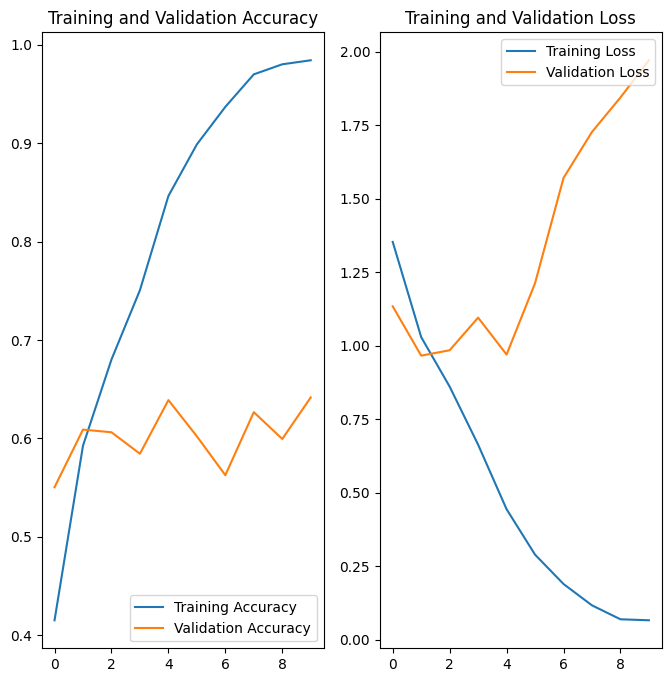

In [8]:
# train the model
epochs = 10 # количество эпох тренировки
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs)

# visualize training and validation results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Решение проблемы переобучения.
Добавляем аугментацию и регуляризацию (Dropout)

In [11]:
model = Sequential([
	# т.к. у нас версия TF 2.6 локально
	layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

	# аугментация
	layers.RandomFlip("horizontal"),
	layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomContrast(0.2),

	# дальше везде одинаково
	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(64, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	# регуляризация
	layers.Dropout(0.2),

	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(num_classes)
])

# compile the model
model.compile(
	optimizer='adam',
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy'])

# print model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_1 (RandomFlip)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast (RandomContrast)     │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

Повторно обучаем нейросеть с новыми слоями и увеличенным количеством эпох обучения

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.2997 - loss: 1.5771 - val_accuracy: 0.5518 - val_loss: 1.0962
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.5656 - loss: 1.0714 - val_accuracy: 0.6076 - val_loss: 1.0102
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.6376 - loss: 0.9387 - val_accuracy: 0.6281 - val_loss: 0.9353
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.6655 - loss: 0.8681 - val_accuracy: 0.6417 - val_loss: 0.9050
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.6915 - loss: 0.8131 - val_accuracy: 0.6608 - val_loss: 0.8274
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.7078 - loss: 0.7772 - val_accuracy: 0.6730 - val_loss: 0.8222
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.7319 - loss: 0.7260 - val_accuracy: 0.7003 - val_loss: 0.7551
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.7328 - loss: 0.7062 - val_accuracy: 0.7071 - v

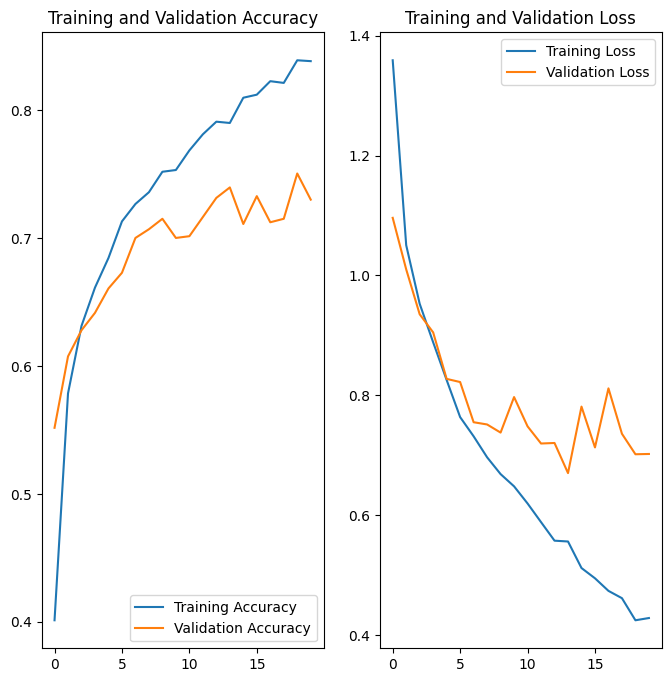

In [12]:
# train the model
epochs = 20 # количество эпох тренировки
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs)

# visualize training and validation results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Делаем инференс на новом изображении

Используем изображение: /content/flower_photos/flower_photos/sunflowers/14623719696_1bb7970208_n.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
На изображении скорее всего sunflowers (100.00% вероятность)


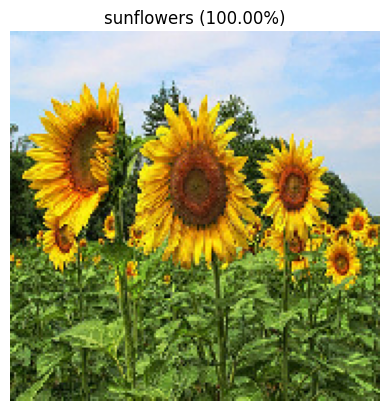

In [29]:
import os
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Загружаем модель
model_file_name = "my_flowers_model.keras"
model = tf.keras.models.load_model(model_file_name)

# Укажи путь к папке с изображениями
sunflower_folder = "/content/flower_photos/flower_photos/sunflowers"

# Проверяем, существует ли папка
if not os.path.exists(sunflower_folder):
    print("Ошибка! Папка не найдена:", sunflower_folder)
else:
    # Получаем список всех изображений
    image_files = [f for f in os.listdir(sunflower_folder) if f.endswith(".jpg")]

    if not image_files:
        print("Ошибка! В папке нет изображений.")
    else:
        # Выбираем случайное изображение
        random_image = random.choice(image_files)
        image_path = os.path.join(sunflower_folder, random_image)

        print("Используем изображение:", image_path)

        # Проверяем, существует ли файл
        if not os.path.exists(image_path):
            print("Ошибка! Файл не найден:", image_path)
        else:
            # Загружаем изображение
            img = tf.keras.utils.load_img(image_path, target_size=(180, 180))

            # Преобразуем изображение в массив
            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)

            # Делаем предсказание
            predictions = model.predict(img_array)
            score = tf.nn.softmax(predictions[0])

            # Классы
            class_names = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

            # Определяем предсказанный класс
            predicted_class = class_names[np.argmax(score)]
            confidence = 100 * np.max(score)

            # Вывод результата
            print(f"На изображении скорее всего {predicted_class} ({confidence:.2f}% вероятность)")

            # Показываем изображение в Google Colab
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"{predicted_class} ({confidence:.2f}%)")
            plt.show()


Экспорт файла модели (скачать себе на компьютер)

In [26]:
from google.colab import files

model_file_name = "my_flowers_model.keras"

# Сохраняем модель в новом формате
model.save(model_file_name)

# Загружаем модель на локальный компьютер
files.download(model_file_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>